# Exercício sobre Transfer Learning

Nesse exercício você irá utilizar uma rede pré-treinada bastante conhecida, a VGG-16 (http://www.robots.ox.ac.uk/~vgg/research/very_deep/). Como tarefa, você irá criar cum classificador utilizado-se de camadas densas no dataset do Cifar-10. As camadas anteriores ao seu classificador deverão ser congeladas, de modo que durante o treino apenas os pesos do seu classificador sejam sintonizados. A opção de congelar menos camadas fica por sua conta. Reporte suas dúvidas e resultados para serem discutidos no próximo dia do curso. Boa sorte!

In [1]:
import numpy as np
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"  

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import h5py

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.datasets import cifar10
from keras.utils import np_utils

import sys
sys.path.append('../src')
from my_keras_utilities import TrainingPlotter, load_model_and_history

K.set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Definição da CNN

In [3]:
# Carrega o modelo da VGG-16 com seus devidos pesos sem as camadas densas (totalmente conectadas)
def get_tr_vgg_model(weights_path, img_width, img_height):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Carrega os pesos necesários até o último bloco da VGG-15 anterior as camadas densas
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    
    print ('Model loaded.')
    
    return model

# Carregando e Normalizando os dados

In [4]:
# Carregando os dados
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()

# Transforma o vetor de labels para o formato de one-hot encoding.
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)

#Normalização dos dados
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

img_width, img_height = X_train.shape[2:]

## Carregando e inicializando pesos da CNN

In [5]:
# Caminho pesos da VGG-16
weights_path = '/root/vgg16_weights.h5'

# Carrega o modelo até a última camada convolucional
vgg16_tr_model = get_tr_vgg_model(weights_path, img_width, img_height)

# Execute esse comando para conhecer a arquitetura das camadas convolucionais da VGG-16
#print vgg16_tr_model.summary()

Model loaded.


## Agora é sua vez!!

Crie um classificador usando camadas densas baseando-se no exmeplo do "cats and dogs 2". 
Dicas: 
    - a dimensão de saída da VGG-16 truncada será a dimensão de entrada do seu novo modelo.
    - a dimensão da saída do classificador é o número de classes do Cifar-10.
    - metódos de combate ao overfitting podem ser utilizados (i.e. dropout)
  

In [6]:
n = len(vgg16_tr_model.layers) # número de camadas que não serão re-treinadas

####### Adicione novas camadas ######
vgg16_tr_model.add(Dropout(0.5))
vgg16_tr_model.add(Flatten())

vgg16_tr_model.add(Dense(128))
vgg16_tr_model.add(Activation('relu'))
vgg16_tr_model.add(Dropout(0.5))

vgg16_tr_model.add(Dense(256))
vgg16_tr_model.add(Activation('relu'))
vgg16_tr_model.add(Dropout(0.5))

vgg16_tr_model.add(Dense(10))
vgg16_tr_model.add(Activation('relu'))

vgg16_tr_model.add(Activation('softmax'))

#####################################


# Execute esse comando para conhecer a nova arquitetura após a adição do seu classificador
#print vgg16_tr_model.summary()

# Congela as camadas até última camada convolucional da VGG-16
for layer in vgg16_tr_model.layers[:n]: 
    layer.trainable = False

[INFO] evaluating...
[INFO] accuracy: 52.53%


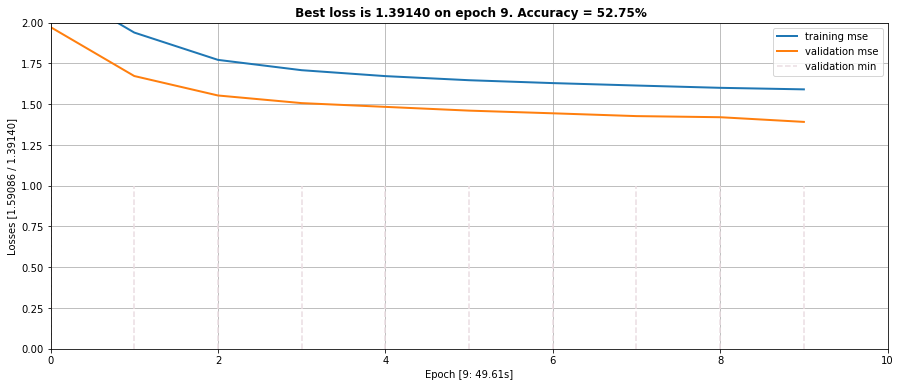

In [7]:
model_name = './minha_rede' # toda vez que mudar o modelo, altere o nome dele
ploss = 2.0
nepochs = 10

#if not os.path.isfile(model_name + '.model'):
print("[INFO] creating model...")
# History, checkpoint, earlystop, plot losses:
my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=10)

# initialize the optimizer and model
print("[INFO] compiling model...")
vgg16_tr_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])    
    
#else:
#    print("[INFO] loading model...")
#    vgg16_tr_model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plt.figure(figsize=(15,6))
plt.ylim(0.0, ploss)
plt.xlim(0, nepochs)
plt.grid(True)

print("[INFO] training...")
try:
    vgg16_tr_model.fit(X_train, Y_train, batch_size=128, nb_epoch=nepochs,
                       verbose=0, validation_split=0.33, callbacks = [my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating...")
loss, accuracy = vgg16_tr_model.evaluate(X_test, Y_test, batch_size=128, verbose=2)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

## Sugestões 

1. Realize uma seleção de modelo para encontrar os melhores parâmetros para o seu classificador.
2. Visualize as imagens de teste em que a sua rede falha.
3. Visualize os features nas saídas das camadas intermediárias da rede.